## Remove most significant gRNA per bin, then redo peak calling

In [1]:
suppressPackageStartupMessages(library(tidyverse))

### Aggregate sgRNA-level effects to call "peaks"

#### Define fisher's method to aggregate p values
 - https://mikelove.wordpress.com/2012/03/12/combining-p-values-fishers-method-sum-of-p-values-binomial/
 - https://www.biostars.org/p/211307/

In [2]:
fishersMethod = function(x) pchisq(-2 * sum(log(x)),df=2*length(x),lower=FALSE)

#### Re-load results (if needed)

In [3]:
krab.res <- read_tsv("deseq2_results/removelowspec.tyckoGATA1krabinterference.deseq2.results.tsv",
                    show_col_types=FALSE)
head(krab.res,n=1)
dim(krab.res)

grna_id,type,d21.vs.plasmid.baseMean,d21.vs.plasmid.log2FoldChange,d21.vs.plasmid.lfcSE,d21.vs.plasmid.stat,d21.vs.plasmid.pvalue,d21.vs.plasmid.padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,230.629,-0.438347,0.3389427,-1.293278,0.195915,0.9999433


[1] 4908    8

#### Load output of bedtools intersect 

Defines "bins" and which sgRNAs belong to each bin after adjusting for perturbation modality.

In [4]:
peaks <- read.delim("grna_library/cutsite.tycko.krab.100step.bed", header = FALSE, 
                    col.names = c("grna.chrom","grna.start","grna.end","grna_id","bin.chr","bin.start","bin.end")) %>%
  mutate(bin = paste0(bin.chr,":",bin.start,"-",bin.end))

head(peaks,n=1)
dim(peaks)

,grna.chrom,grna.start,grna.end,grna_id,bin.chr,bin.start,bin.end,bin
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,chrX,48686619,48686621,chrX:48686620-48686623,chrX,48686400,48686500,chrX:48686400-48686500


[1] 36197     8

#### Subset DESeq2 results for only targeting sgRNAs

In [5]:
pam <- krab.res %>%
  filter(type == "tiling")

head(pam,n=1)
dim(pam)

grna_id,type,d21.vs.plasmid.baseMean,d21.vs.plasmid.log2FoldChange,d21.vs.plasmid.lfcSE,d21.vs.plasmid.stat,d21.vs.plasmid.pvalue,d21.vs.plasmid.padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,230.629,-0.438347,0.3389427,-1.293278,0.195915,0.9999433


[1] 4906    8

### Remove most significant sgRNA per bin, then redo peak calling

We noticed that DESeq2 had the most unique peak calls. The unique peak calls could be driven by a single sgRNA within a bin due to how the p-value of the bin was calculated. To test this, we want to remove the most significant sgRNA per bin, then recalculate the bin statistics.

In [70]:
pam %>%
  left_join(peaks, by = "grna_id") %>%
  filter(grepl("chrX",bin)) %>%
group_by(bin) %>%
mutate(grna_count = n()) %>%
top_n(n = first(grna_count - 1), d21.vs.plasmid.pvalue) %>%
mutate(new_count = n()) %>%
# arrange(bin, d21.vs.plasmid.pvalue) %>%
summarise(n = n(),
          fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
          mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
          max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
          bin.mid = (bin.end+bin.start)/2) %>%
select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin, 
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
select(bin) %>%
distinct() %>%
count() %>% pull()

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


[1] 107

#### Generate final "peak" calls by merging adjacent bins (after removing the most significant gRNA per bin)

In [6]:
pam %>%
  left_join(peaks, by = "grna_id") %>%
  filter(grepl("chrX",bin)) %>%
group_by(bin) %>%
mutate(grna_count = n()) %>%
top_n(n = first(grna_count - 1), d21.vs.plasmid.pvalue) %>%
mutate(new_count = n()) %>%
# arrange(bin, d21.vs.plasmid.pvalue) %>%
summarise(n = n(),
          fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
          mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
          max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
          bin.mid = (bin.end+bin.start)/2) %>%
select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin, 
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
select(chrom, start, end) %>%
distinct() %>%
write.table("/data/gersbachlab/lrb53/encodeCrisprWG/finalversion/figure4/deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.hg38.bed",
            col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


### Switch to `python` kernel

#### Sort bins and then merge adjacent bins to generate final peak calls

In [1]:
%%bash
head -n 1 deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.hg38.bed
wc -l deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.hg38.bed

chrX	48782600	48782700
107 deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.hg38.bed


In [2]:
%%bash

sort -k1,1 -k2,2n deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.hg38.bed > deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.hg38.bed
head -n1 deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.hg38.bed
wc -l deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.hg38.bed

chrX	48782600	48782700
107 deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.hg38.bed


In [3]:
%%bash
module load bedtools2

bedtools merge -d 1 -i deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.hg38.bed > deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.merge.hg38.bed

head -n 1 deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.merge.hg38.bed
wc -l deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.merge.hg38.bed


chrX	48782600	48783800
11 deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.merge.hg38.bed


The total peak count reduced from 21 to 11 peaks after removing the most significant gRNA per bin. This further suggests that the aggregation of DESeq2 approach is suspectible to false positives by low spec guides/off-target effects and other noise (signal being driven by a single perturbation).

#### Intersect peak calls from other methods 

In [1]:
%%bash
module load bedtools2

bedtools multiinter -i /data/gersbachlab/lrb53/encodeCrisprWG/manuscript/gata1.commonregion.hg38.bed \
deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.merge.hg38.bed \
/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/CASA__filtered_tycko_gata1_growth__replicatingPeaks.coords.bed \
/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/crisprsurf_significant_regions_corrected.merged.bed \
/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/mageck_filtered_Bassik_GATA1_CRISPRi_PLAvT21.merged.bed \
/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/bassik_crispri_gata1growth.removelowspec_RELICS_final_k1_FS_locations.sorted.merge.bed -header -names \
> upset/GATA1.tyckoCrispri.deseq2removemostsig.txt

head upset/GATA1.tyckoCrispri.deseq2removemostsig.txt

chrom	start	end	num	list	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/gata1.commonregion.hg38.bed	deseq2_peakcalls/removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.merge.hg38.bed	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/CASA__filtered_tycko_gata1_growth__replicatingPeaks.coords.bed	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/crisprsurf_significant_regions_corrected.merged.bed	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/mageck_filtered_Bassik_GATA1_CRISPRi_PLAvT21.merged.bed	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/bassik_crispri_gata1growth.removelowspec_RELICS_final_k1_FS_locations.sorted.merge.bed
chrX	48696667	48697047	1	4	0	0	0	1	0	0
chrX	48697067	48697227	1	4	0	0	0	1	0	0
chrX	48702727	48702867	1	4	0	0	0	1	0	0
chrX	48732248	48732404	1	6	0	0	0	0	0	1
chrX	48737607	48737707	1	4	0	0	0	1	0	0
chrX	48745252	48761747	1	1	1	0	0	0	0	0
chrX	48761747	48761948	2

### Change to `R`

### Load packages

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(UpSetR))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggplotify))

### Common region coordinates

In [2]:
commonregion <- read.delim("/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/gata1.commonregion.hg38.bed", header = FALSE,
                           col.names = c("chrom","start","end"))
head(commonregion)

,chrom,start,end
,<chr>,<int>,<int>
1,chrX,48745252,48821194


### Now, generate the upset plot

In [3]:
## Tycko KRAB (aggrDESeq2, CASA, CRISPR-SURF, MAGeCK, RELICS) 

df <- read.delim("upset/GATA1.tyckoCrispri.deseq2removemostsig.txt", header = TRUE) %>%
  mutate(name = paste0(chrom,":",start,"-",end)) %>%
#   filter(chrom == commonregion$chrom) %>%
#   filter(start >= commonregion$start) %>%
#   filter(end <= commonregion$end) %>%
  rename(casa = `X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.newpeakcalls.CASA__filtered_tycko_gata1_growth__replicatingPeaks.coords.bed`,
         deseq2 = `deseq2_peakcalls.removelowspec.removeMostSigGrna.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.sorted.merge.hg38.bed`,
         surf = `X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.newpeakcalls.crisprsurf_significant_regions_corrected.merged.bed`,
         mageck =`X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.newpeakcalls.mageck_filtered_Bassik_GATA1_CRISPRi_PLAvT21.merged.bed`,
         relics = `X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.newpeakcalls.bassik_crispri_gata1growth.removelowspec_RELICS_final_k1_FS_locations.sorted.merge.bed`)

head(df,n=1)
dim(df)
colnames(df)

,chrom,start,end,num,list,X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.gata1.commonregion.hg38.bed,deseq2,casa,surf,mageck,relics,name
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,chrX,48696667,48697047,1,4,0,0,0,1,0,0,chrX:48696667-48697047


[1] 75 12

[1] "chrom"                                                                         
 [2] "start"                                                                         
 [3] "end"                                                                           
 [4] "num"                                                                           
 [5] "list"                                                                          
 [6] "X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.gata1.commonregion.hg38.bed"
 [7] "deseq2"                                                                        
 [8] "casa"                                                                          
 [9] "surf"                                                                          
[10] "mageck"                                                                        
[11] "relics"                                                                        
[12] "name"

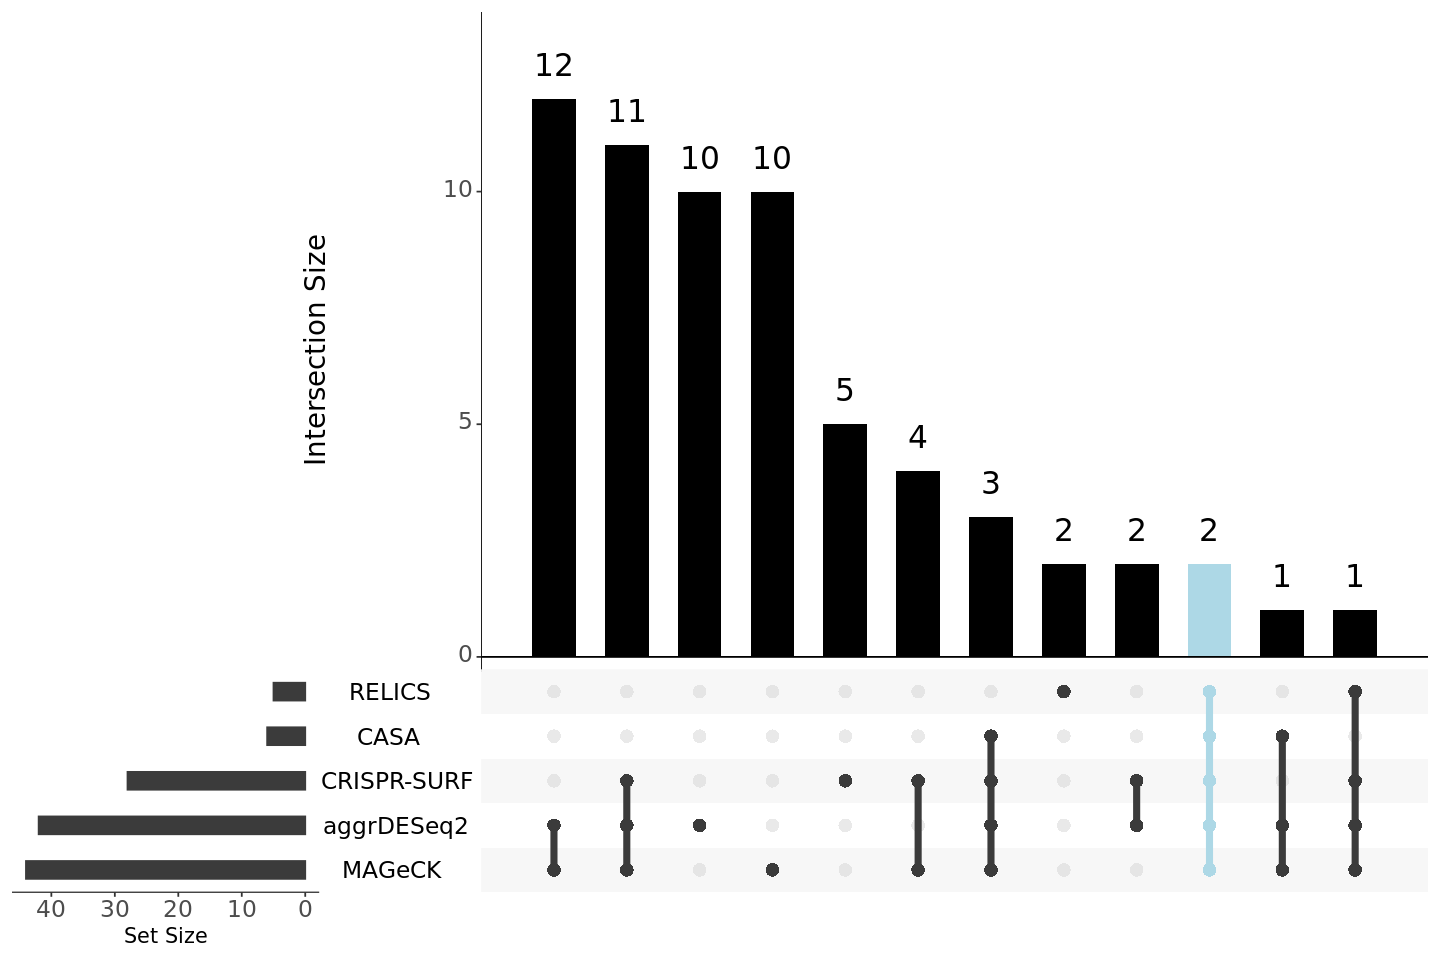

In [4]:
options(repr.plot.width = 12, repr.plot.height = 8)
# region <- df %>% filter(commonregion_coords == 1) %>% select(name) %>% distinct() %>% pull()
screen1 <- df %>% filter(casa == 1) %>% select(name) %>% distinct() %>% pull()
screen2 <- df %>% filter(deseq2 == 1) %>% select(name) %>% distinct() %>% pull()
screen3 <- df %>% filter(surf == 1) %>% select(name) %>% distinct() %>% pull()
screen4 <- df %>% filter(mageck == 1) %>% select(name) %>% distinct() %>% pull()
screen5 <- df %>% filter(relics == 1) %>% select(name) %>% distinct() %>% pull()


# listInput <- list("common_region" = region, 
#                   "CASA" = screen1, 
#                   "aggrDESeq2" = screen2, 
#                   "CRISPR-SURF" = screen3, 
#                   "MAGeCK" = screen4, 
#                   "RELICS" = screen5
#                  )

listInput <- list("CASA" = screen1, 
                  "aggrDESeq2" = screen2, 
                  "CRISPR-SURF" = screen3, 
                  "MAGeCK" = screen4, 
                  "RELICS" = screen5
                 )

p9 <- upset(fromList(listInput), 
      order.by = "freq",
      nsets = 6,
      queries = list(list(query = intersects, params = list("CASA","aggrDESeq2","MAGeCK","CRISPR-SURF","RELICS"), color = "lightblue", active = T)),
      # set_size.show = TRUE, ### these do not look good when added in R, add later in Illustrator
      # set_size.numbers_size = 5,
      point.size = 3.5, 
      line.size = 2, 
      mainbar.y.label = "Intersection Size", 
      sets.x.label = "Set Size", 
      main.bar.color = "black", 
      text.scale = c(2, 2, 1.5, 2, 2, 3) # intersection size title, intersection size tick labels, set size title, set size tick labels, set names, numbers above bars
      ) 

p9

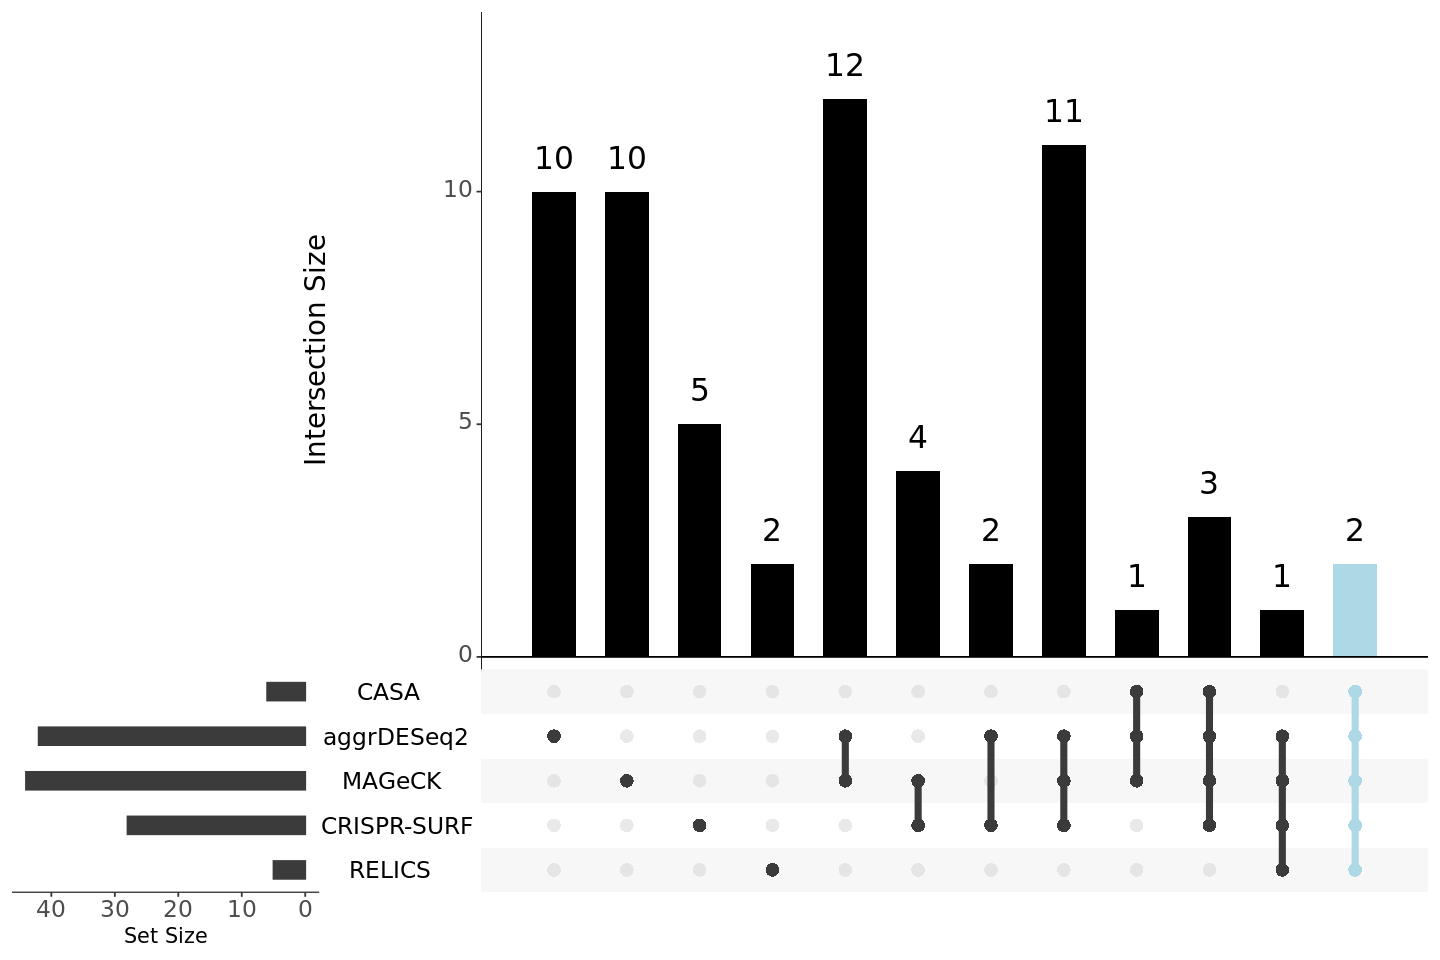

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8)
# region <- df %>% filter(commonregion_coords == 1) %>% select(name) %>% distinct() %>% pull()
screen1 <- df %>% filter(casa == 1) %>% select(name) %>% distinct() %>% pull()
screen2 <- df %>% filter(deseq2 == 1) %>% select(name) %>% distinct() %>% pull()
screen3 <- df %>% filter(surf == 1) %>% select(name) %>% distinct() %>% pull()
screen4 <- df %>% filter(mageck == 1) %>% select(name) %>% distinct() %>% pull()
screen5 <- df %>% filter(relics == 1) %>% select(name) %>% distinct() %>% pull()


# listInput <- list("common_region" = region, 
#                   "CASA" = screen1, 
#                   "aggrDESeq2" = screen2, 
#                   "CRISPR-SURF" = screen3, 
#                   "MAGeCK" = screen4, 
#                   "RELICS" = screen5
#                  )

listInput <- list("CASA" = screen1, 
                  "aggrDESeq2" = screen2, 
                  "CRISPR-SURF" = screen3, 
                  "MAGeCK" = screen4, 
                  "RELICS" = screen5
                 )

p9 <- upset(fromList(listInput), 
      #order.by = "freq",
      keep.order=TRUE,
      #nsets = 6,
      #sets = c("CASA","RELICS","MAGeCK","CRISPR-SURF","aggrDESeq2"),
      #sets = c("CASA","aggrDESeq2","MAGeCK","CRISPR-SURF","RELICS"),
      sets = c("RELICS","CRISPR-SURF","MAGeCK","aggrDESeq2","CASA"),
      #sets = c("aggrDESeq2","CRISPR-SURF","MAGeCK","RELICS","CASA"),
      queries = list(list(query = intersects, params = list("CASA","aggrDESeq2","MAGeCK","CRISPR-SURF","RELICS"), color = "lightblue", active = T)),
      # set_size.show = TRUE, ### these do not look good when added in R, add later in Illustrator
      # set_size.numbers_size = 5,
      point.size = 3.5, 
      line.size = 2, 
      mainbar.y.label = "Intersection Size", 
      sets.x.label = "Set Size", 
      main.bar.color = "black", 
      text.scale = c(2, 2, 1.5, 2, 2, 3) # intersection size title, intersection size tick labels, set size title, set size tick labels, set names, numbers above bars
      ) 

p9